In [3]:
import xarray as xr
import zarr
import numpy as np
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('/workspace/bkraft/dl_chapter14/src')
from utils.plotting import plot_map, subplots_robinson, plot_scatter, plot_hist2d, plot_hexbin
from utils.metrics import get_metrics, xr_percentile

### Data

In [4]:
ds = xr.open_zarr('/scratch/dl_chapter14/experiments/hydro/default/pred/predictions.zarr/')

In [8]:
xr_percentile(ds.mrro, dim='time')

<xarray.DataArray '0.5-percentile' (lat: 360, lon: 720)>
dask.array<percentile_gufunc, shape=(360, 720), dtype=float64, chunksize=(10, 10), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 -179.75 -179.25 -178.75 ... 178.75 179.25 179.75
Attributes:
    long_name:  0.5-percentile
    units:      kg/m2/s

### Spatial analysis

In [4]:
# met = get_metrics(ds.mrro, ds.mrro_obs, ['corr', 'rmse', 'mef'])
met = get_metrics(ds.mrro, ds.mrro_obs, ['corr'])

11/11/2019, 10:29:11: calculating metrics [corr, rmse, mef]
11/11/2019, 10:29:11: - corr


/workspace/bkraft/dl_chapter14/src/utils/metrics.py:31: RuntimeWarning: Mean of empty slice
  x -= np.nanmean(x, axis=-1, keepdims=True)
/workspace/bkraft/dl_chapter14/src/utils/metrics.py:32: RuntimeWarning: Mean of empty slice
  y -= np.nanmean(y, axis=-1, keepdims=True)
/opt/conda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/workspace/bkraft/dl_chapter14/src/utils/metrics.py:34: RuntimeWarning: invalid value encountered in true_divide
  cov = np.nansum(x * y, axis=-1) / valid_count
/workspace/bkraft/dl_chapter14/src/utils/metrics.py:31: RuntimeWarning: Mean of empty slice
  x -= np.nanmean(x, axis=-1, keepdims=True)
/opt/conda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/workspace/bkraft/dl_chapter14/src/utils/metrics.py:31: RuntimeWarning: Mean of empty slice
  x -= np.nanmean(x, axis=-1, keepdims=True)


11/11/2019, 10:29:31: - rmse
11/11/2019, 10:29:43: - mef
11/11/2019, 10:29:58: done; elapsed time: 0 min 46 sec


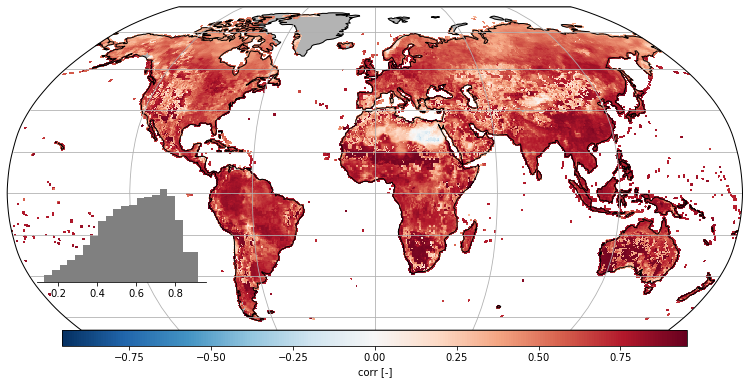

In [17]:
plot_map(met.corr)

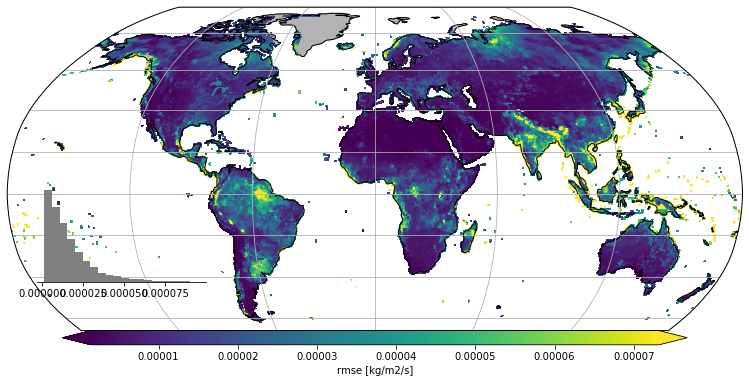

In [13]:
plot_map(met.rmse, robust=True)

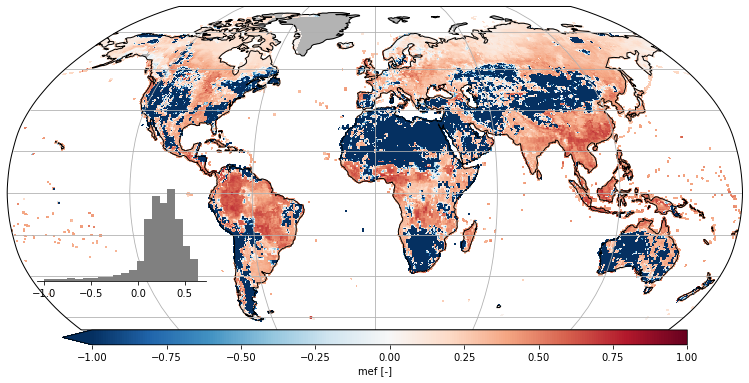

In [11]:
plot_map(met.mef, vmin=-1)

In [6]:
def plot_time_series(
        x, y,
        xlabel='mod', ylabel='obs',
        title='',
        ax=None,
        subplot_kw={},
        use_mean=True,
        **kwargs):

    time = x.time.values
    x_q = x.quantile([0.2, 0.8], dim=('lat', 'lon'))
    y_q = y.quantile([0.2, 0.8], dim=('lat', 'lon'))

    if use_mean:
        x_m = x.mean(dim=('lat', 'lon'))
        y_m = y.mean(dim=('lat', 'lon'))
    else:
        x_m = x.median(dim=('lat', 'lon'))
        y_m = y.median(dim=('lat', 'lon'))
        
    
    corr = np.corrcoef(x_m, y_m)[0, 1]

    ax.fill_between(time, x_q.isel(quantile=0), x_q.isel(quantile=1), alpha=0.2, facecolor='tab:blue', label=r'$modeled_{q0.2-0.8}$')
    ax.fill_between(time, y_q.isel(quantile=0), x_q.isel(quantile=1), alpha=0.2, facecolor='k', label=r'$observed_{q0.2-0.8}$')
    ax.plot(time, x_m, alpha=1.0, color='tab:blue', linewidth=2., label=r'$modeled_{median}$')
    ax.plot(time, y_m, color='k', linewidth=1.2, linestyle='--', label=r'$observed_{median}$')

    ax.text(0.05, 0.95, f'r={N_r:.3f}', horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)
    
    ax.set_ylabel(var)

    ax.patch.set_facecolor('white')

In [7]:
plot_time_series(ds.mrro, ds.mrro_obs)

TypeError: quantile does not work for arrays stored as dask arrays. Load the data via .compute() or .load() prior to calling this method.

In [1]:
plt.figure(figsize=(14, 8))
plot_map((ds.mrro.sel(time='2013-06-31')-ds.mrro_obs.isel(time=0)), robust=True)

NameError: name 'plt' is not defined

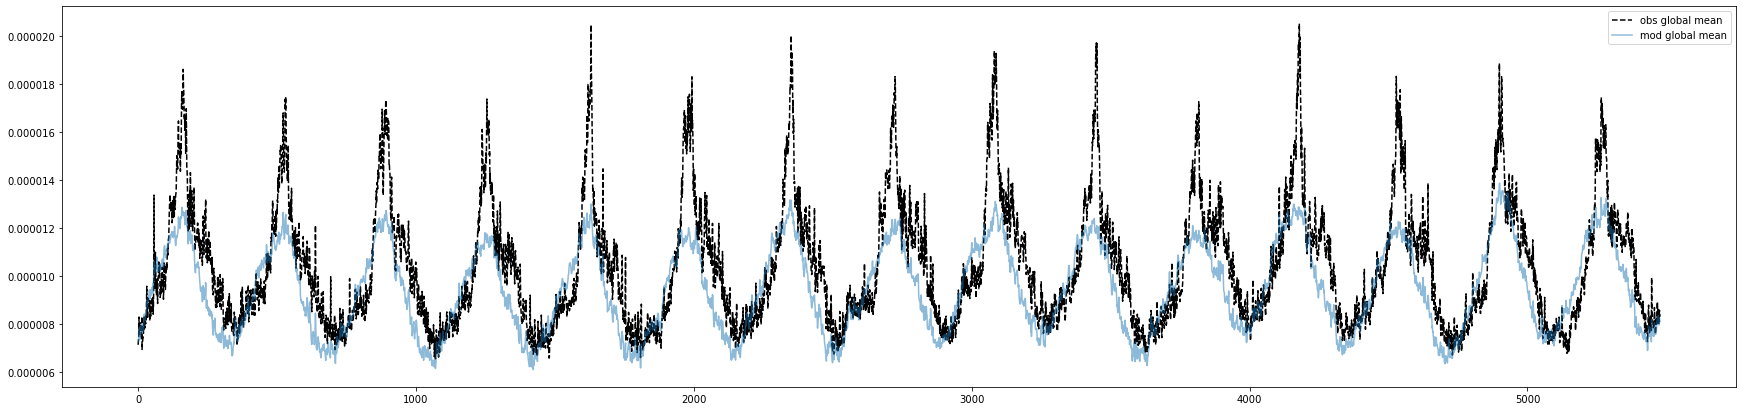

In [21]:
plt.figure(figsize=(30, 7))

plt.plot(ds.mrro_obs.mean(('lat', 'lon')), 'k--', label='obs global mean')
plt.plot(ds.mrro.mean(('lat', 'lon')), alpha=0.5, label='mod global mean')
plt.legend()

In [28]:
import numpy as np
import matplotlib.pyplot as plt

In [114]:
def f0(x):
    return x**(-0.5)
def f1(x):
    return x**(-0.2) + 0.01 * x
def f_gl(x):
    gl = np.zeros_like(x)
    for t, v in enumerate(x):
        gl[t] = 100 * (v / np.min(x[:t+1]) - 1)
    return gl
def f_min(x):
    m = np.zeros_like(x)
    for t, v in enumerate(x):
        m[t] = np.min(x[:t+1])
    return m

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


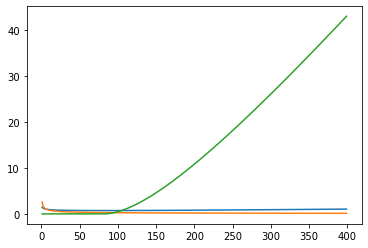

In [124]:
t = np.linspace(0, 60, 400)
e_tr = f0(t)
e_va = f1(t)
gl = f_gl(e_va)
gl_tr = f_gl(e_tr)
plt.plot(e_va)
plt.plot(e_tr)
plt.plot(gl)
# plt.plot(gl_tr)

In [141]:
def f_gl(x):
    per_impr = np.zeros_like(x)
    for t in range(1, len(x)):
        per_impr[t] = 100 * (1 - x[t] / x[t-1])
    return per_impr

In [142]:
gl = f_gl(e_va)

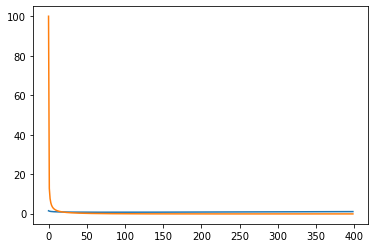

In [143]:
plt.plot(e_va[1:])
plt.plot(gl[1:])

In [25]:
import pandas as pd

In [27]:
df = pd.read_csv('/scratch/dl_chapter14/experiments/hydro/default/cv/hydro/Emulator_0_2019-11-11_08-42-07m_hccusr/progress.csv')

EmptyDataError: No columns to parse from file

In [199]:
df

,epoch,loss_train,loss_eval,patience_counter,perc_improved,best_loss,done,timesteps_total,episodes_total,training_iteration,...,timestamp,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,trial_id
0,1,1.300028e-09,5.944167e-10,0,0.000000,5.944167e-10,False,NaN,NaN,1,...,1573404119,95.269621,95.269621,12967,8d43effa4b71,172.17.0.6,95.269621,0,1,c3511f40
1,2,1.309272e-09,5.815003e-10,0,2.172953,5.815003e-10,False,NaN,NaN,2,...,1573404213,94.573489,189.843110,12967,8d43effa4b71,172.17.0.6,189.843110,0,2,c3511f40
2,3,1.274369e-09,5.733385e-10,0,1.403578,5.733385e-10,False,NaN,NaN,3,...,1573404309,95.571095,285.414205,12967,8d43effa4b71,172.17.0.6,285.414205,0,3,c3511f40
3,4,1.194475e-09,5.709449e-10,0,0.417483,5.709449e-10,False,NaN,NaN,4,...,1573404405,96.205045,381.619250,12967,8d43effa4b71,172.17.0.6,381.619250,0,4,c3511f40
4,5,1.250227e-09,5.724166e-10,1,-0.257755,5.709449e-10,False,NaN,NaN,5,...,1573404501,95.896864,477.516114,12967,8d43effa4b71,172.17.0.6,477.516114,0,5,c3511f40
5,6,1.119440e-09,5.715308e-10,2,-0.102611,5.709449e-10,False,NaN,NaN,6,...,1573404596,94.940071,572.456184,12967,8d43effa4b71,172.17.0.6,572.456184,0,6,c3511f40
6,7,1.130880e-09,5.606235e-10,0,1.807775,5.606235e-10,False,NaN,NaN,7,...,1573404692,95.375186,667.831370,12967,8d43effa4b71,172.17.0.6,667.831370,0,7,c3511f40
7,8,1.091978e-09,5.612418e-10,1,-0.110277,5.606235e-10,False,NaN,NaN,8,...,1573404786,94.430029,762.261399,12967,8d43effa4b71,172.17.0.6,762.261399,0,8,c3511f40
8,9,9.497963e-10,5.516027e-10,0,1.609082,5.516027e-10,False,NaN,NaN,9,...,1573404881,94.711263,856.972662,12967,8d43effa4b71,172.17.0.6,856.972662,0,9,c3511f40
9,10,9.247447e-10,5.443904e-10,0,1.307516,5.443904e-10,False,NaN,NaN,10,...,1573404976,94.985668,951.958331,12967,8d43effa4b71,172.17.0.6,951.958331,0,10,c3511f40


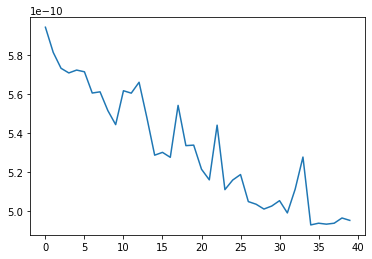

In [200]:
plt.plot(df['loss_eval'])

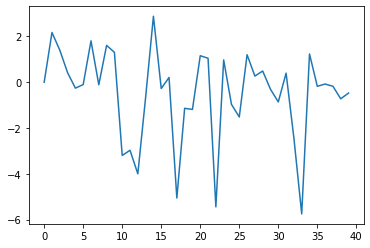

In [201]:
plt.plot(df['perc_improved'])

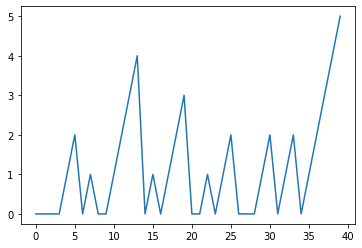

In [202]:
plt.plot(df['patience_counter'])

In [23]:
l = {'a': 1, 'b': 2}
options_str = ", ".join(l.keys())
print(f'[{options_str}]')

[a, b]


'a, b'

In [30]:
print(f'{getattr.__name__}')

getattr


In [31]:
from datetime import datetime

In [33]:
tic = datetime.now()

In [34]:
tic.strftime("%m/%d/%Y, %H:%M:%S")

'11/11/2019, 09:38:00'

In [35]:
toc = datetime.now()

In [42]:
elapsed = toc- tic

In [43]:
elapsed.seconds

302

In [45]:
mins = int(elapsed.seconds/60)
mins

5

In [46]:
secs = int(elapsed.seconds - 60 * mins)
secs

2

In [3]:
import xarray as xr
import numpy as np
import zarr

In [11]:
ds_ssd = zarr.open_group('/scratch/dl_chapter14/experiments/hydro/default/pred/predictions.zarr/')
ds_ram = zarr.open_group('/run/user/196')
ds_ram.tree()

/
 ├── lat (360,) float32
 ├── lon (720,) float32
 ├── mrro (5478, 360, 720) float32
 ├── mrro_obs (5478, 360, 720) float32
 └── time (5478,) int64

In [14]:
def read_zarr(ds, n):
    for i in range(n):
        lat = np.random.choice(360)
        lon = np.random.choice(720)
        s = ds['mrro'][:, lat, lon] + 1

In [15]:
%time read_zarr(ds_ssd, 1000)

CPU times: user 300 ms, sys: 2.21 s, total: 2.51 s
Wall time: 2.5 s


In [16]:
%time read_zarr(ds_ssd, 1000)

CPU times: user 288 ms, sys: 2.27 s, total: 2.56 s
Wall time: 2.55 s


In [17]:
ls -l /run/user/1968

ls: cannot access '/run/user/1968': No such file or directory


In [ ]:
/scratch/